# Long-term veg cover fractions (Trees, Grass, Bare)

Following [Donohue 2009](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2486.2008.01746.x)

In [1]:
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs
import matplotlib.pyplot as plt

## Analysis Parameters

In [8]:
# enter NDVI value of bare soil (or path to perpixel estimate)
ndvi_min = '/g/data/xc0/project/AusEFlux/data/ndvi_of_baresoil_5km.nc'

# likely maximum NDVI
ndvi_max = 0.91

#ndvi data is here
ndvi_path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022_0.2.0.nc'

#Export location
results_path = '/g/data/os22/chad_tmp/Aus_phenology/data/'

## Open NDVI data

In [ ]:
ds = xr.open_dataset(ndvi_path)['AusENDVI_clim_MCD43A4']

## Plot soil signal NDVI

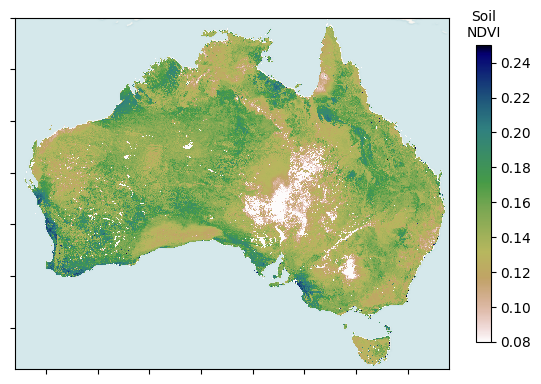

In [54]:
import contextily as ctx

ndvi_min = xr.open_dataset(ndvi_min)['NDVI']

fig,ax=plt.subplots(1,1, figsize=(7,7))
im = ndvi_min.plot(cmap='gist_earth_r', vmin=0.08, vmax=0.25, ax=ax, add_labels=False, add_colorbar=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
cbar = fig.colorbar(im, orientation='vertical',
                ax=ax,
                cmap='gist_earth_r',
                shrink=0.55
               )
cbar.ax.set_title('Soil\nNDVI', fontsize=10);
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/soil_signal_ndvi.png',
            bbox_inches='tight', dpi=300);

## Define function

In [ ]:
def _vegetation_fractions(
    ds, #ndvi data
    ndvi_min=0.141,
    ndvi_max=0.91,
    dask_chunks=None#dict(latitude=250, longitude=250, time=-1
):
    """
    Calculate per-pixel fraction of trees, grass, bare using the methods defined by
    Donohue et al. (2009).

    Requires NDVI (not any other vegetation index).

    `ndvi_min` is the minimum NDVI that a pixel can achieve, this can either be
    a float (e.g 0.141) or a path to a per-pixel estimate of minimum NDVI. 
    
    """
    
    # NDVI value of bare soil (supplied by Luigi Renzullo)
    if isinstance(ndvi_min, str): 
        ndvi_min = xr.open_dataarray(ndvi_min)

    #calculate f-total
    ft = (ds - ndvi_min) / (ndvi_max - ndvi_min)
    ft = xr.where(ft<0, 0, ft)
    ft = xr.where(ft>1, 1, ft)
    
    #calculate initial persistent fraction (equation 1 & 2 in Donohue 2009)
    persist = ft.rolling(time=7, min_periods=1).min()
    persist = persist.rolling(time=9, min_periods=1).mean()
    
    #calculate initial recurrent fraction (equation 3 in Donohue 2009)
    recurrent = ft - persist
    
    ###------- equations 4 & 5 in Donohue 2009----------------
    persist = xr.where(recurrent<0, persist - np.abs(recurrent), persist) #eq4
    recurrent = ft - persist # eq 5
    ## ---------------------------------------------------------
    
    #ensure values are between 0 and 1
    persist = xr.where(persist<0, 0, persist)
    recurrent = xr.where(recurrent<0, 0, recurrent)
    
    #assign variable names
    recurrent.name='grass'
    persist.name='trees'
    
    # # Aggregate to annual layers
    # # Use the maximum fraction of trees and grass to create annual layers.
    # # Bare soil is the residual
    # persist_annual = persist.resample(time='1YE').max().compute()
    # recurrent_annual = recurrent.resample(time='1YE').max().compute()
    # bare_annual = 1-(persist_annual+recurrent_annual)
    # bare_annual.name='bare'

    
    # # add right metadata
    # persist_annual.attrs['nodata'] = np.nan
    # recurrent_annual.attrs['nodata'] = np.nan
    # bare_annual.attrs['nodata'] = np.nan
    
    # persist_annual = assign_crs(persist_annual, crs='EPSG:4326')
    # recurrent_annual = assign_crs(recurrent_annual, crs='EPSG:4326')
    # bare_annual = assign_crs(bare_annual, crs='EPSG:4326')

    # return persist_annual, recurrent_annual, bare_annual
    return persist, recurrent

## Calculate veg fractions

In [ ]:
# trees, grass, bare = _vegetation_fractions(
#     ds, #ndvi data
#     ndvi_min=ndvi_min,
#     ndvi_max=0.91
# )

trees, grass = _vegetation_fractions(
    ds, #ndvi data
    ndvi_min=ndvi_min,
    ndvi_max=0.91
)

## Plot individual year

In [ ]:
year = '2022'

In [ ]:
fig,ax=plt.subplots(1,3, figsize=(15,5), sharey=True, layout='constrained')
trees.sel(time=year).squeeze().plot.imshow(ax=ax[0], cmap='gist_earth_r', add_colorbar=False, add_labels=False) #vmax=1, vmin=0,
grass.sel(time=year).squeeze().plot.imshow(ax=ax[1], cmap='gist_earth_r', add_colorbar=False, add_labels=False)
bare.sel(time=year).squeeze().plot.imshow(ax=ax[2], vmin=0, cmap='gist_earth_r', add_labels=False)

ax[0].set_title(f'Persistent fraction {year}')
ax[1].set_title(f'Recurrent fraction {year}')
ax[2].set_title(f'Bare fraction {year}');

### Plot Aus-wide time-series

In [ ]:
fig,ax=plt.subplots(1,1, figsize=(12,4))
trees.mean(['latitude', 'longitude']).plot(ax=ax, label='Persistent')
grass.mean(['latitude', 'longitude']).plot(ax=ax, label='Recurrent')
ax.legend()
plt.ylabel('Land cover fractions')
plt.title('Mean fractions across Australia')
ax.grid()
ax.set_xlabel(None)
# ax.set_ylim(0.1,0.25);
# bare.mean(['latitude', 'longitude']).plot(ax=ax, label='bare')

### Export annual files 

In [ ]:
trees.to_netcdf(f'{results_path}trees_fraction.nc')
grass.to_netcdf(f'{results_path}grass_fraction.nc')
# bare.to_netcdf(f'{results_path}bare_fraction.nc')